# Define the experimental ratios of elements


--> ERROR: The Zn element is not accepted by the pitzer database

--> ERROR: The Ni element is not accepted by the pitzer database

--> ERROR: The Cu element is not accepted by the pitzer database

--> ERROR: The Cd element is not accepted by the pitzer database

--> ERROR: The Co element is not accepted by the pitzer database

--> ERROR: The Pb element is not accepted by the pitzer database




Estimated completion in 3.80E1 seconds by 2021-12-18 18:21:37.792838 local time.


C:\Users\Andrew Freiburger\AppData\Roaming\Python\Python37\site-packages\sigfig\sigfig.py:572: UserWarning: warning: 3 significant figures requested from number with only 2 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
C:\Users\Andrew Freiburger\AppData\Roaming\Python\Python37\site-packages\sigfig\sigfig.py:572: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


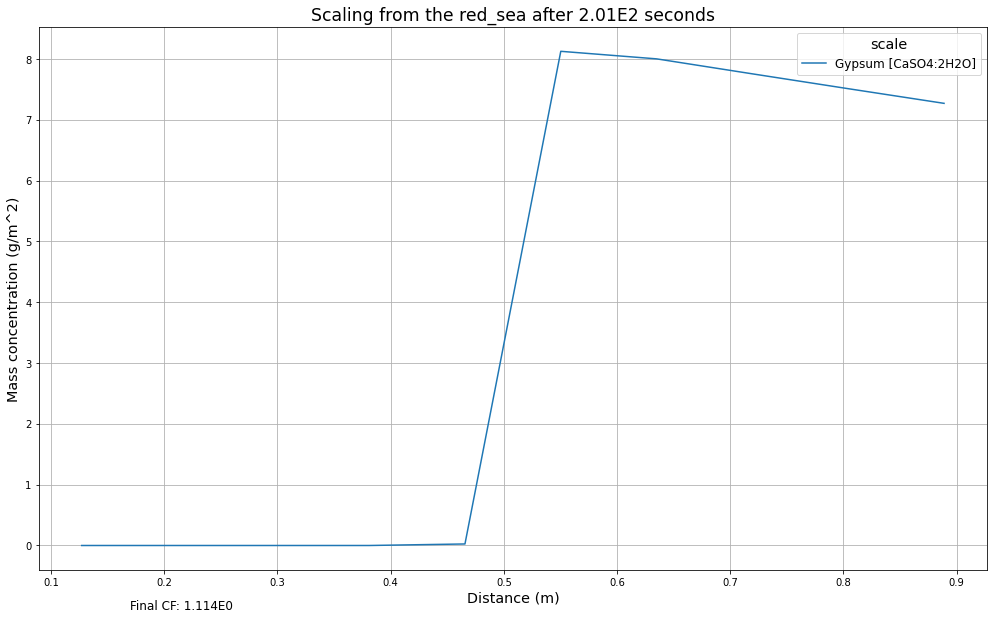

,Gypsum (g/m^2)
Distance (m),
1.27E-1,0.00E0
2.12E-1,0.00E0
2.96E-1,0.00E0
3.81E-1,0.00E0
4.66E-1,2.51E-2
5.50E-1,8.13E0
6.35E-1,8.00E0
7.20E-1,7.76E0
8.04E-1,7.51E0


In [3]:
# run the ROSS model
%run ../../../rosspy/core.py
ross = ROSSPkg(verbose = False)

# initial parameters
database_selection = 'pitzer'
water_selection = 'red_sea'
simulation_perspective = 'all_distance'
simulation_time = 200

# create the input file
ross.define_general(database_selection)
ross.transport(simulation_time, simulation_perspective, )
ross.reaction()
ross.solutions(water_selection)
ross.equilibrium_phases()
ross.selected_output()
ross.export()

# execute and process the input file
raw_data = ross.execute()
distance_data = ross.process_selected_output()
display(distance_data)

In [81]:
from chemicals import periodic_table
from pprint import pprint
import json
import re

elements = {}
for element in periodic_table:
    elements[element.symbol] = element.MW
    
# calculate the masses of each element in each scalant
mineral_elements = {}
stoich = None
total = 0
for column in distance_data:
    mineral = re.search('([A-Za-z]+)', column).group()
    database = json.load(open(f'./../../../rosspy/databases/{database_selection}.json'))
    formula = database["minerals"][mineral]['formula']
    formula = re.sub(':[0-9+]H2O|\(OH\)[0-9]+', '', formula)
    mineral_elements[mineral] = {}

    index = 0
    for ch in formula:
        if re.search('[A-Z]', ch):
            element = ch
            if re.search('[a-z]', formula[index+1]):
                element += formula[index+1]
                if re.search('[0-9]', formula[index+2]):
                    stoich = float(formula[index+2])
                else:
                    stoich = 1
            elif re.search('[0-9]', formula[index+1]):
                stoich = float(formula[index+1])
            else:
                stoich = 1
        elif re.search('[0-9]', ch):
            continue
            
        if element in elements:
            if stoich:
                mass = elements[element] * stoich
                total += mass
                mineral_elements[mineral][element] = mass
                stoich = None
                element = None
        
        index += 1
    
    mineral_elements[mineral]['total'] = total
    print(mineral, formula)

print(mineral_elements)

# determine the ionic proportions of the respective mineral, without solvated water or hydroxide
elemental_ratio = {}
for mineral in mineral_elements:
    elemental_ratio[mineral] = {}
    for element in mineral_elements[mineral]:
        elemental_ratio[mineral][element] = mineral_elements[mineral][element] / mineral_elements[mineral]['total']
        
print(elemental_ratio)

# calculate the precipitated mass of each element
scale_ratio = {}
index = 0
for mineral in elemental_ratio:
    scale_ratio[mineral] = {}
    for scale in distance_data[f'{mineral} (g/m^2)']:  
        df_index = distance_data.index[index]
        scale_ratio[mineral][df_index] = {}
        for element in elemental_ratio[mineral]:
            scale_ratio[mineral][df_index][element] = elemental_ratio[mineral][element] * float(scale)
            
        index += 1
    
message = '\n\n(g/m^2) of elements per distance in the module'
print(message, '\n', '='*len(message))
pprint(scale_ratio)

Gypsum CaSO4
{'Gypsum': {'Ca': 40.078, 'S': 32.065, 'O': 63.9976, 'total': 136.1406}}
{'Gypsum': {'Ca': 0.2943868324364664, 'S': 0.23552856385237025, 'O': 0.4700846037111633, 'total': 1.0}}


(g/m^2) of elements per distance in the module 
{'Gypsum': {'1.27E-1': {'Ca': 0.0, 'O': 0.0, 'S': 0.0, 'total': 0.0},
            '2.12E-1': {'Ca': 0.0, 'O': 0.0, 'S': 0.0, 'total': 0.0},
            '2.96E-1': {'Ca': 0.0, 'O': 0.0, 'S': 0.0, 'total': 0.0},
            '3.81E-1': {'Ca': 0.0, 'O': 0.0, 'S': 0.0, 'total': 0.0},
            '4.66E-1': {'Ca': 0.007389109494155307,
                        'O': 0.0117991235531502,
                        'S': 0.005911766952694493,
                        'total': 0.0251},
            '5.50E-1': {'Ca': 2.393364947708472,
                        'O': 3.821787828171758,
                        'S': 1.9148472241197703,
                        'total': 8.13},
            '6.35E-1': {'Ca': 2.3550946594917312,
                        'O': 3.7606768296893063,
 